In [14]:
from editor import Editor
from Box2D.b2 import pi

# edit your model by running this cell
# to add a body part hit b and it will spawn under your mouse
# to move body parts drag them with the mouse
# to connect body parts, hit p to pin two bodies at the mouse location
# to change a body part's size, click and hold, then use the arrow keys to modify width/height
# hit 's' to save while editing to model.json

editor = Editor()
editor.load('creatures/pole.json')
editor.run()

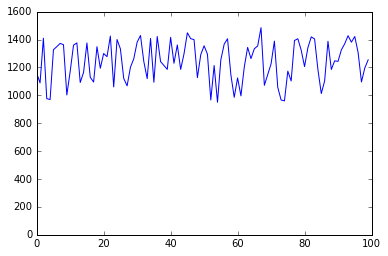

episode: 300 multiplier: 0.2


In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
import pygame
from pygame.locals import (KEYDOWN, K_RIGHT, K_LEFT, K_UP, K_DOWN, K_r, K_s)
from Box2D.b2 import pi
from engine import Engine
from time import sleep

# train your model to (hopefully) walk by running this cell

# hit s to speed up training, and s again to watch the best set of weights
# use the up and down arrow keys to introduce more or less randomness in weight changes


FILE = 'creatures/human.json'
WEIGHT_FILE = None

TIMESTEPS = 120 # timesteps per episode
HIDDEN = 32

# Physics engine and window
LOWER_LIM = -.2 * np.pi
UPPER_LIM = .2 * np.pi
LIMIT = True
ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0

engine = Engine(caption='Train', width=1280, height=720, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, linear_damping=0.0, angular_damping=0.0)

# Add floor
engine.add_static_body(p=(engine.width/2, engine.height-10), size=(engine.width * 10, 10))

# Load creature
engine.load(FILE)

body_count = len(engine.world.bodies) - 1 # subtract ground body
joint_count = len(engine.world.joints)

if body_count == 0 or joint_count == 0:
    engine.close()
    raise RuntimeError("Your model doesn't have any physics bodies or joints")

def features(time_step=0):
    f = []
    
    for b in engine.world.bodies:
        if b.userData and isinstance(b.userData, dict):
            a = b.angle % ANGLE_RANGE
            a /= ANGLE_RANGE
            a = a * 2.0 - 1.0
            f += [a]
    
    f += [np.sin(time_step / 2.0)] # Creature's heartbeat? :-)
    
    return np.array([f])
    
def body_position():
    avg = np.zeros([2])
    for b in engine.world.bodies:
        if b.userData:
            avg += [b.position[0], b.position[1]]
    avg /= body_count
    return engine.to_screen(avg)

def set_position(position, zero_vel=True):
    current = engine.to_pybox2d(body_position())
    position = engine.to_pybox2d(position)
    shift = (position[0] - current[0], position[1] - current[1])
    for b in engine.world.bodies:
        if b.userData:
            if zero_vel:
                b.linearVelocity = (0, 0)
                b.angularVelocity = 0
            b.position = (b.position[0] + shift[0], b.position[1] + shift[1])
            
class Weights(object):
    def __init__(self, W1, W2):
        self.W1 = W1.copy()
        self.W2 = W2.copy()
        
    def save(self, filename):
        ws = np.array([self.W1, self.W2])
        np.save(filename, ws)
        
    @staticmethod
    def restore(filename):
        ws = np.load(filename)
        W1 = ws[0]
        W2 = ws[1]
        return Weights(W1, W2)
        
    def feed_forward(self, features):
        z1 = features.dot(self.W1)
        h1 = relu(z1)
        z2 = h1.dot(self.W2)
        z2 = np.tanh(z2)
        return z2
    
    def modify(self, multiplier=1.0):
        self.W1 *= .9
        self.W2 *= .9
        self.W1 += np.random.randn(self.W1.shape[0], self.W1.shape[1]) * multiplier
        self.W2 += np.random.randn(self.W2.shape[0], self.W2.shape[1]) * multiplier
        
    def mix(self, w2, amount=.5):
        if amount == 0:
            return
        self.W1 = self.W1 * (1.0 - amount) + w2.W1 * amount
        self.W2 = self.W2 * (1.0 - amount) + w2.W2 * amount
    
    def copy(self):
        return Weights(self.W1, self.W2)
        
rs = []
total_r = 0.0
episode = 0
max_r = float('-inf')

multiplier = 1.0

best_ws = []
best_w = None
w = None

def init_w():
    global best_w, best_ws, w
    
    W1 = np.random.randn(features().shape[1], HIDDEN)
    W2 = np.random.randn(HIDDEN, joint_count)
    
    if WEIGHT_FILE:
        best_w = Weights.restore(WEIGHT_FILE)
        best_ws += [best_w]
    else:
        best_w = Weights(W1, W2)
        
    w = Weights(W1, W2)
    
def relu(x):
    return x * (x > 0)

def act(features, w):
    out = w.feed_forward(features)
    
    for i, j in enumerate(engine.world.joints):
        j.motorSpeed = out[0, i] * 4
    
init_w()

speedup = False
running = True

while running:
    rs.append(total_r)
    
    if episode % 50 == 0:
        clear_output(wait=True)
        if len(rs) > 100:
            rs = rs[-100:]
        fig = plt.plot(rs, 'b')
        plt.plot([0, len(rs)], [0, 0], 'r')
        plt.show()

        print('episode: {} multiplier: {}'.format(episode, np.round(multiplier, 2)))
    
    if total_r > max_r and episode != 0:
        max_r = total_r
        
        best_w = w.copy()
        best_ws.insert(0, best_w)
        if len(best_ws) > 5:
            best_ws = best_ws[:5]
        
    if speedup:
        w = np.random.choice(best_ws).copy()
        w.mix(np.random.choice(best_ws), amount=.5)
        w.modify(multiplier)
    elif len(best_ws) != 0:
        w = best_ws[0]

    # new episode
    engine.clear_all_but_ground()
    engine.load(FILE)
    
    set_position((engine.width/2, engine.height/2))
    
    for j in engine.world.joints:
        j.motorSpeed = np.random.randn()
    
    engine.step_physics(5)
    for b in engine.world.bodies:
        b.linearVelocity = (0, 0)
        b.angularVelocity = 0
    
    t = 0
    total_r = 0.0
    episode += 1
    last_p = body_position()
    
    reset = False
    while not reset:
        # keyboard input
        for event in engine.events():
            if engine.quit_event(event):
                running = False
                reset = True
            if event.type == KEYDOWN:
                k = pygame.key.get_pressed()
                if k[K_UP]:
                    multiplier += 0.05
                elif k[K_DOWN]:
                    multiplier -= 0.05
                elif k[K_s]:
                    speedup = not speedup
                    if not speedup:
                        reset = True
                multiplier = max(min(multiplier, 3), 0)
        
        # step physics engine
        act(features(t), w)
        engine.step_physics(1)
        
        # reward
        #new_p = body_position()
        reward = np.average([b.position[1] for b in engine.world.bodies])
        #reward += (new_p[0] - last_p[0])
        
        total_r += reward
                                     
        if t > TIMESTEPS:
            reset = True
        
        if not speedup:
            engine.render()
            engine.clock_tick()

        # prepare for next rounds
        last_p = body_position()
        t += 1

engine.close()

In [49]:
# run this cell to save the best set of weights
# you can load it by setting WEIGHT_FILE to the name of the file above

best_ws[0].save('human_goto_point_ws')